# Seattle Crime Data Exploration

- [Introduction and Objective](#Introduction-and-Objective)
- [Package Imports](#Package-Imports)
- [Crime Data Wrangling](#Crime-Data-Wrangling)
    - [Request SPD Crime Data via Open Data API](#Request-SPD-Crime-Data-via-OpenData-API)
    - [Transform Data into DataFrame](#Transform-Data-into-DataFrame)
    - [Handle Missing Data](#Handle-Missing-Data)
    - [Parse DataFrame Columns](#Parse-DataFrame-Columns)
    - [Select Consistently Reported Data](#Select-Consistently-Reported-Data)
- [Precinct Shape Data Wrangling](#Precinct-Shape-Data-Wrangling)
    - [Match Crime Data and Shape Data Discarding Discrepancies](#Match-Crime-Data and-Shape-Data-Discarding-Discrepancies)
- [Visualize Data](#Visualize-Data)
    - [Choropleth Map](#Choropleth-Map)
    - [Bar Plot of Offenses by Beat](#Bar-Plot-of-Offenses-by-Beat)
    - [Examine Offense Correlations Across Beats](#Examine-Offense-Correlations-Across-Beats)
- [Predictive Modeling I: Assaults Across Beats](#Predictive-Modeling-I:-Assaults-Across-Beats)
    - [Least Squares Model and LOOCV Test MSE Estimate](#Least-Squares-Model-and-LOOCV-Test-MSE-Estimate)
    - [Lasso Regression Model and LOOCV Test MSE Estimate](#Lasso-Regression-Model-and-LOOCV-Test-MSE-Estimate)
    - [Actionable Insights](#Actionable-Insights)
- [Predictive Modeling II: Assaults in Time](#Predictive-Modeling-II:-Assaults-in-Time)
    - [Visualize Assaults by Month](#Visualize-Assaults-by-Month) 
    - [Assault Time Series in a Beat](#Visualize-Assault-Time-Series-in-a-Beat)
    - [Lag Plot of Assaults in a Beat](#Lag-Plot-of-Assaults-in-a-Beat)
    - [Autoregressive Model of Assaults](#Autoregressive-Model-of-Assaults)
    - [Auto-Correlations of Assaults in Time](#Auto-Correlations-of-Assaults-in-Time)
    - [Autoregressive Model of Assaults](#Autoregressive-Model-of-Assaults)
    - [AR Model Fit](#AR-Model-Fit)
    - [Actionable Insights](#Actionable-Insights)

## Introduction and Objective

In this project we will look at crime data from the Seattle Police Dept. The data has three primary features: 1. It contains an offense types (assaults, robberies etc), 2. an incident time (year-month-day-time) and 3. A geographic location specified by latitude and longitude

## Package Imports

In [3]:
# Import os related packages
import os
import sys
import glob

# standard packages
import requests
import simplejson as json
import numpy as np
import pandas as pd
import folium
import statsmodels.api as sm

# standard tools
from collections import defaultdict
from datetime import date
# Plotting tools
from IPython.display import HTML
from matplotlib import pyplot as plt
from pandas.tools.plotting import lag_plot
# sklearn tools
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.cross_validation import cross_val_score
# statsmodels tools
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.stattools import adfuller

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

## Data Wrangling

### Request SPD Crime Data via Open Data API

We are now going to request the latest crime data from Seattle's Open Data API. We will specifically be requesting a json formatted response. Since we are only going to make a single request we do not need to concern ourselves with using an api-key. One would want to do this if you planned on making many request and were concerned about throttling limits (see https://dev.socrata.com/).

In [5]:
if not glob.glob('data/data.txt'):
    print('Connecting to seattle.gov API Endpoint...')
    # Force flush the above print from stdout buffer
    sys.stdout.flush()
    
    # get a json response from the seattle.gov API endpoint
    # Note we are using the 'report incident' data not the 'incident response'
    #url = "https://data.seattle.gov/resource/pu5n-trf4.json"
    url = "https://data.seattle.gov/resource/y7pv-r3kh.json"
    response = requests.get(url)
    
    # if status code good dump the data to file
    if response.status_code == 200:
        data = response.json()
        with open('data/data.txt', 'w') as outfile:
            json.dump(data, outfile)
            print('Success!')
            
    else: print('Http Status Code:', response.status_code)
    
else:
    print('Loading data from file...')
    sys.stdout.flush()
    # Load the serialized json file obj
    with open('data.txt', 'r') as infile:
        data = json.load(infile)
    print('Loading Complete')

Connecting to seattle.gov API Endpoint...
Success!


### Transform Data into DataFrame 

In [6]:
# Lets take a look at the first entry in the data dict to see how the data is organized
data[0]

{':@computed_region_kuhn_3gp2': '42',
 ':@computed_region_q256_3sug': '17919',
 ':@computed_region_ru88_fbhk': '42',
 'census_tract_2000': '9500.2063',
 'date_reported': '2011-09-04T04:20:00.000',
 'district_sector': 'R',
 'general_offense_number': '2011291522',
 'hundred_block_location': 'RAINIER AV S / S WALKER ST',
 'latitude': '47.583656311',
 'location': {'coordinates': [-122.3022, 47.583656], 'type': 'Point'},
 'longitude': '-122.302200317',
 'month': '9',
 'occurred_date_or_date_range_start': '2011-09-04T04:20:00.000',
 'offense_code': '3550',
 'offense_code_extension': '0',
 'offense_type': 'NARC-EQUIPMENT/PARAPHENALIA',
 'rms_cdw_id': '985381',
 'summarized_offense_description': 'NARCOTICS',
 'summary_offense_code': '3500',
 'year': '2011',
 'zone_beat': 'R2'}

In [7]:
# Define what pieces of data we want for a dataframe
columns = ['occurred_date_or_date_range_start', 'summarized_offense_description','zone_beat',
           'latitude', 'longitude',]

In [8]:
# transform the data dict into a list of incidents keeping only pertinent data values
data_list = []
for incident in data:
    data_list.append([incident[column] if column in list(incident.keys()) else np.nan for column in columns])

In [9]:
# convert the list of incidents to a dataframe object
df = pd.DataFrame(data = data_list, columns=columns)
df.rename(columns= {'occurred_date_or_date_range_start':'datetime','summarized_offense_description': 'offense',
                    'zone_beat':'beat'}, inplace=True)

In [10]:
df.head()

,datetime,offense,beat,latitude,longitude
0,2011-09-04T04:20:00.000,NARCOTICS,R2,47.583656311,-122.302200317
1,2011-09-04T05:04:00.000,ASSAULT,L3,47.698345184,-122.277740479
2,2011-09-04T00:08:00.000,PROPERTY DAMAGE,B2,47.666423798,-122.369682312
3,2011-03-03T20:30:00.000,CAR PROWL,L2,47.687610626,-122.314315796
4,2011-08-30T18:00:00.000,CAR PROWL,U1,47.665672302,-122.304534912


In [11]:
# List all possible types of offenses in the data
df.offense.unique()

array(['NARCOTICS', 'ASSAULT', 'PROPERTY DAMAGE', 'CAR PROWL',
       'BIKE THEFT', 'STOLEN PROPERTY', 'OTHER PROPERTY', 'BURGLARY',
       'VEHICLE THEFT', 'PICKPOCKET', 'TRESPASS', 'ROBBERY',
       'WARRANT ARREST', 'LOST PROPERTY', 'SHOPLIFTING', 'DISTURBANCE',
       'LIQUOR VIOLATION', 'FRAUD', 'THREATS', 'PUBLIC NUISANCE', 'WEAPON',
       'DISPUTE', 'BURGLARY-SECURE PARKING-RES', 'MAIL THEFT', 'EMBEZZLE',
       'PROSTITUTION', 'FALSE REPORT', 'OBSTRUCT', 'FORGERY',
       'ILLEGAL DUMPING', 'THEFT OF SERVICES', 'ANIMAL COMPLAINT',
       'TRAFFIC', 'INJURY', 'COUNTERFEIT', 'VIOLATION OF COURT ORDER',
       'PURSE SNATCH', 'HOMICIDE', 'RECKLESS BURNING', 'HARBOR CALLS',
       'RECOVERED PROPERTY', 'DUI', 'ELUDING', '[INC - CASE DC USE ONLY]',
       'PORNOGRAPHY', 'BIAS INCIDENT', 'DISORDERLY CONDUCT', 'FIREWORK',
       'STAY OUT OF AREA OF DRUGS', 'ESCAPE', 'EXTORTION', 'LOITERING',
       'STAY OUT OF AREA OF PROSTITUTION', 'HARBOR CALLs',
       'FRAUD AND FINANCIAL', 'GA

### Describe and Handle Missing Data

The first difficulty we encounter with this dataset is missing values. We can take care of these by dropping these rows.

In [12]:
# This dataset is missing data. How many rows have at least one NaN?
num_missing_rows = df.isnull().any(axis=1).sum()
print(num_missing_rows, 'rows are missing a value. This comprises',
      num_missing_rows/len(df)*100,'% of the', len(df), 'rows of the data')

# How many are missing from each column?
print('\n__MISSING ROWS BY COLUMN__')
print(df.isnull().sum(axis=0))

1 rows are missing a value. This comprises 0.00014609780079 % of the 684473 rows of the data

__MISSING ROWS BY COLUMN__
datetime     1
offense      1
beat         1
latitude     1
longitude    1
dtype: int64


In [13]:
# We are only missing 1 row... Hooray SPD!
df = df.dropna()

### Parse DataFrame Columns

In [14]:
# Now convert the datetime, latitude and longitude from strings to datetime objs and floats

# create parser for the latitude and longitude cols
def parse_float(x):
    try:
         return float(x)
    except ValueError:
        print('Could not convert', x, 'to float.', ' Setting x=nan')
        return np.nan   
    
# Apply the parser to create floats of latitude and longitude strings
df.latitude = df.latitude.apply(parse_float)
df.longitude = df.longitude.apply(parse_float)

# convert the date strings to datetime objects, coerce will return NaTs if not convertible
df.datetime = pd.to_datetime(df.datetime, errors='coerce')
df.head(3)

,datetime,offense,beat,latitude,longitude
0,2011-09-04 04:20:00,NARCOTICS,R2,47.583656,-122.302200
1,2011-09-04 05:04:00,ASSAULT,L3,47.698345,-122.277740
2,2011-09-04 00:08:00,PROPERTY DAMAGE,B2,47.666424,-122.369682


### Select Consistently Reported Data

The second difficulty we find in this dataset is that data was not consistently collected prior to 2009. Lets show why this is the case.

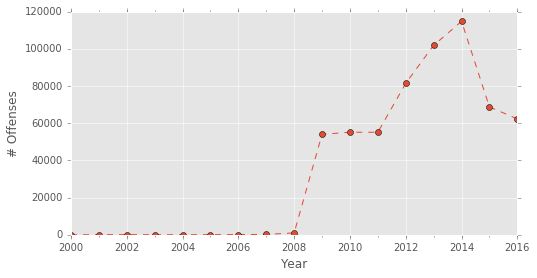

In [15]:
# Lets look at the total number of offenses over time to see how well the data has been collected
df = df.set_index('datetime')
# get the min and max datetimes
min_time = df.index.min()
max_time = df.index.max()

# construct time range
rng = pd.date_range(min_time, max_time, freq='AS')

# count the offenses by getting length of sliced dataframe
offense_counts = [len(df[(df.index > min_time) & (df.index < max_time)]) 
                  for min_time, max_time in zip(rng, rng[1:])] 

# Plot data
s=pd.Series(offense_counts, index=rng[1:])
ax = s.plot(figsize=(8,4), linestyle='--', marker='o', xlim=('2000','2016'));
ax.set_xlabel('Year');
ax.set_ylabel('# Offenses');

In [16]:
# So we see that data collection didn't really start all the way back to 1965 (earliest date). So we will need 
# to drop all data prior to 2009. This will leave us with 7 years of data to examine (~622,000 incidents)
df = df[df.index>'2009']
df = df.sort_index()
# reset the index back to integers
df = df.reset_index()

In [17]:
# We also are going to drop the following offenses: Harbor Calls, FRAUD AND FINANCIAL, METRO, 
# and [INC - CASE DC USE ONLY]  because the number of offenses is extremely low.
print(len(df))
print('FRAUD AND FINANCIAL = ', len(df[df.offense=='FRAUD AND FINANCIAL']))
print('HARBOR CALLS', len(df[df.offense=='HARBOR CALLS']))
print('HARBOR CALLs', len(df[df.offense=='HARBOR CALLs']))
print('METRO', len(df[df.offense=='METRO']))
print('[INC - CASE DC USE ONLY]', len(df[df.offense=='[INC - CASE DC USE ONLY]']))
df = df.drop(df[df.offense.isin(['FRAUD AND FINANCIAL','HARBOR CALLS','HARBOR CALLs',
                                 'METRO','[INC - CASE DC USE ONLY]'])].index)
print(len(df))
df.head()

628613
FRAUD AND FINANCIAL =  3
HARBOR CALLS 10
HARBOR CALLs 8
METRO 1
[INC - CASE DC USE ONLY] 51
628540


,datetime,offense,beat,latitude,longitude
0,2009-01-01 00:01:00,STOLEN PROPERTY,D2,47.616053,-122.336166
1,2009-01-01 00:01:00,OTHER PROPERTY,C3,47.621270,-122.286870
2,2009-01-01 00:01:00,FRAUD,U3,47.658432,-122.289743
3,2009-01-01 00:01:00,BURGLARY,D1,47.618596,-122.353751
4,2009-01-01 00:01:00,FRAUD,L3,47.718304,-122.292753


## Precinct Shape Data Wrangling

The crime data we just wrangled has the police beats or precincts. This gives us the opportunity to explore spatially where offenses are occurring, but we need a shapefile that describes the boundaries of each of the police beats. Fortunately, this again is available through Seattles Open Data Api.

In [29]:
if not glob.glob('data/*.geojson'):
    print('Connecting to seattle.gov API Endpoint...')
    # Force flush the above print from stdout buffer
    sys.stdout.flush()
    
    # get a json response from the seattle.gov API endpoint
    url = "https://data.seattle.gov/resource/sa45-gthe.json"
    response = requests.get(url)
    
    # if status code good dump the data to file
    if response.status_code == 200:
        spd_beats = response.json()
        with open('data/spd_beats.geojson', 'w') as outfile:
            json.dump(spd_beats, outfile)
            print('Success!')
            
    else: print('Http Status Code:', response.status_code)
    
else:
    print('Loading data from file...')
    sys.stdout.flush()
    # Load the serialized json file obj
    with open('data/spd_beats.json', 'r') as infile:
        spd_beats = json.load(infile)
    print('Loading Complete')

Loading data from file...
Loading Complete


### Match Crime Data and Shape Data Discarding Discrepancies

We now need to take a look at the json file and see how it is organized so we can extract the latitudes and longitudes for each of the police beats.

In [30]:
#spd_beats[0]

In [31]:
# Perfect, notice we just got something for free... we now have the population in each beat
# lets make sure the beats from the shapefile match the beats from the incident reports

# get the beats from the json dict
geo_beats = [spd_beats[el]['beat'] for el in range(len(spd_beats))]
# get the beats from the incident report data
data_beats = df.beat.unique()

# lets start by comparing the number of beats (data_beats has three more...)
print('data_beats =', len(data_beats),'|  geo_beats =', len(geo_beats))

# get all the beats in data_beats not in geo_beats 
beat_diffs = set(df.beat.values)-set(geo_beats)
print('\n beat_diffs', beat_diffs)

# if we remove data from our dataframe corresponding to these beats how much do we lose?
print('\n',{beat:len(df[df['beat']==beat]) for beat in beat_diffs})

data_beats = 51 |  geo_beats = 51

 beat_diffs set()

 {}


In [32]:
# So if we drop the dataframe rows that have these beats we lose ~ 1500 events out of 677,000.
df = df.drop(df[df['beat'].isin(beat_diffs)].index)

# just check that the beat diffs is now None
beat_diffs = set(df.beat.values)-set(geo_beats)
print('\n beat_diffs', beat_diffs)


 beat_diffs set()


In [33]:
# lets also pull out the population of each beat. This might come in handy...
populations = {spd_beats[el]['beat']:spd_beats[el]['population'] for el in range(len(spd_beats))}

In [34]:
# Later, we are going to need to center lat/longitude of each beat visualization
centroids = defaultdict(list)
for el, _ in enumerate(spd_beats):
    beat = spd_beats[el]['beat']
    centroids[beat] = np.mean(np.array(spd_beats[el]['the_geom']['coordinates'][0][0]), axis=0)

    # I also tried using max and min but this still doesn't hit center of each oddly shaped beat
    # boundary = np.array(spd_beats[el]['the_geom']['coordinates'][0][0])
    #long = (np.max(boundary[:,0])- np.min(boundary[:,0]))/2.0 + np.min(boundary[:,0])
    #lat = (np.max(boundary[:,1])- np.min(boundary[:,1]))/2.0 + np.min(boundary[:,1])
    #centroids[beat] = [lat, long]

## Visualize Data

** We are going to take several approaches to examine this data visually. The dataset is rich, it contains both qualitative and quantitative features. For example, a given offense (qualitative variable) has a set of corresponding quantitative variables (location, and time).**  

### Choropleth Map

We will start with a choropleth map. This type of map shows the number of events for each beat across time. While not the most useful map type, it does provide a bird's eye view of where particular crimes are occuring spatially. We will write a function that can take a given offense type found in the dataframe's offense column and return a choropleth map object. 

On a technical note, I am using folium, a python package that allows python to interact with leaflet.js library for geospatial visaulization (see https://folium.readthedocs.io/en/latest/)

In [35]:
# def display(m, height=300):
#     """Takes a folium instance and embed HTML."""
#     m._build_map()
#     srcdoc = m.HTML.replace('"', '&quot;')
#     embed = HTML('<iframe srcdoc="{0}" '
#                  'style="width: 100%; height: {1}px; '
#                  'border: none"></iframe>'.format(srcdoc, height))
#     return embed

In [43]:
def choropleth(df, offense='ASSAULT'):
    """
    Generates a Choropleth Map displaying the total (over time) of the number of offenses.
    
    PARAMETERS
    ----------
    df      : dataframe object
    offense : string matching one of the offense types in df.offense column
    
    RETURNS
    -------
    choropleth map object
    """
    # group the dataframe by beat and offense
    grouped_data = pd.DataFrame(df.groupby(['beat','offense'])['datetime'].count())
    # unstack the last level 'offenses' to be the columns
    beat_totals = grouped_data.unstack()
    # drop the 'datetime' level from the column index
    beat_totals.columns = beat_totals.columns.droplevel()
    
    # delete columns name and reset index back to integers (folium uses columns 
    # of df so we need to reset index to integer)
    del beat_totals.index.name
    del beat_totals.columns.name
    
    beat_totals = beat_totals.reset_index()

    # set the look-up path of the geojson file
    spd_zones = 'data/SPD_BEATS.geojson'
    
    # create custom threshold for color scaling
    threshold = list(np.linspace(0, max(beat_totals[offense]), 6))
    
    beat_totals.to_json('crimeagg.json')

    # make a map
    m = folium.Map([df.latitude[0],df.longitude[0]], zoom_start=10)#, width='50%', height='75%')
    
    # add choropleth data to map
    m.choropleth(geo_path=spd_zones,
                data=beat_totals,
                columns=['index', offense],
                key_on='feature.properties.name',
                threshold_scale = threshold,
                fill_color='YlOrRd', fill_opacity = 0.6, line_opacity = 0.0,
                legend_name=offense)
    
    # add a marker at the centroid location of each beat
    
    [folium.CircleMarker(centroids[beat][::-1], popup=beat,radius=150).add_to(m) for beat in list(centroids.keys())]

    m.create_map(path='data/choropleth.html')
    
# call choropleth... Note the mean location of the markers is not very good.
# a better procedure for calculating the center of each beat is needed...
choropleth(df,'ASSAULT')

/home/giladmeir/.local/lib/python3.5/site-packages/ipykernel/__main__.py:52: FutureWarning: Map.create_map is deprecated. Use Map.save instead


In [44]:
%%HTML
<iframe width="100%" height="350" src="data/choropleth.html"></iframe>

### Bar Plot of Offenses by Beat

The Choropleth is pretty but not all that useful. To examine the data more quanitatively we now make a bar plot for the number of offenses across beats. 

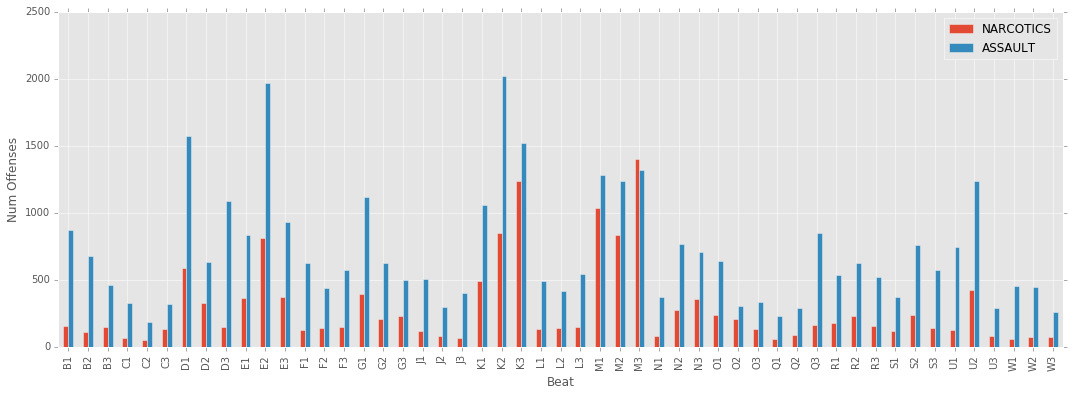

In [45]:
def offense_by_beat(df, offense = None, num_offenses=5):
    """
    Bar plots offenses across beats.
    
    PARAMETERS
    -----------
    df:           crime dataframe with cols: datetime, offense, beat, latitude and longitude
    offenses:     list of offenses in dataframe to plot (default=None)
    num_offenses: if offenses is None, plot returns the top num_offenses (default=5)
    
    RETURNS
    beat_totals: dataframe with beat as index and offenses as columns with offense counts as values.
    -------
    bar plot
    """
    # Get the offenses to plot
    if offense is None:
        # get the top num_offenses
        offense_totals = df.groupby('offense').count()['beat'].sort_values(ascending=False)
        top_offenses = list(offense_totals.iloc[0:num_offenses].index)
    else:
        top_offenses = offense
        
    # group the dataframe by beat and offense
    grouped_data = pd.DataFrame(df.groupby(['beat','offense'])['datetime'].count())
    # unstack the last level 'offenses' to be the columns
    beat_totals = grouped_data.unstack()
    # drop the 'datetime' level from the column index
    beat_totals.columns = beat_totals.columns.droplevel()
    
    # delete the index name and column name
    del beat_totals.index.name
    del beat_totals.columns.name
    
    barPlot = beat_totals[top_offenses].plot(kind='bar', figsize=(18,6), stacked=False);
    barPlot.set_xlabel('Beat')
    barPlot.set_ylabel('Num Offenses')
    
    return beat_totals
    
beat_totals = offense_by_beat(df, ['NARCOTICS', 'ASSAULT'])

This has provided us with our first piece of useful information. From this plot we see that the number of assault offenses and narcotics offenses seem to be correlated across the police beats.

In [46]:
# Make sure we understand what beat_totals returned from bar plot looks like...
beat_totals.head(2)

,ANIMAL COMPLAINT,ASSAULT,BIAS INCIDENT,BIKE THEFT,BURGLARY,BURGLARY-SECURE PARKING-RES,CAR PROWL,COUNTERFEIT,DISORDERLY CONDUCT,DISPUTE,...,STAY OUT OF AREA OF PROSTITUTION,STOLEN PROPERTY,THEFT OF SERVICES,THREATS,TRAFFIC,TRESPASS,VEHICLE THEFT,VIOLATION OF COURT ORDER,WARRANT ARREST,WEAPON
B1,19.0,868.0,3.0,361.0,1205.0,264.0,2179.0,23.0,2.0,56.0,...,NaN,342.0,38.0,496.0,64.0,304.0,962.0,44.0,367.0,47.0
B2,34.0,678.0,NaN,502.0,1800.0,156.0,3218.0,27.0,9.0,81.0,...,1.0,462.0,19.0,470.0,93.0,202.0,1742.0,53.0,380.0,45.0


### Examine Offense Correlations Across Beats

In the Bar plot we noted that across beats the number of assault offenses and narcotic offenses appear correlated. Beats with higher Narcotic offenses seem to have higher Assault offenses. Lets look at a few sample scatter plots and then examine the correlation matrix.

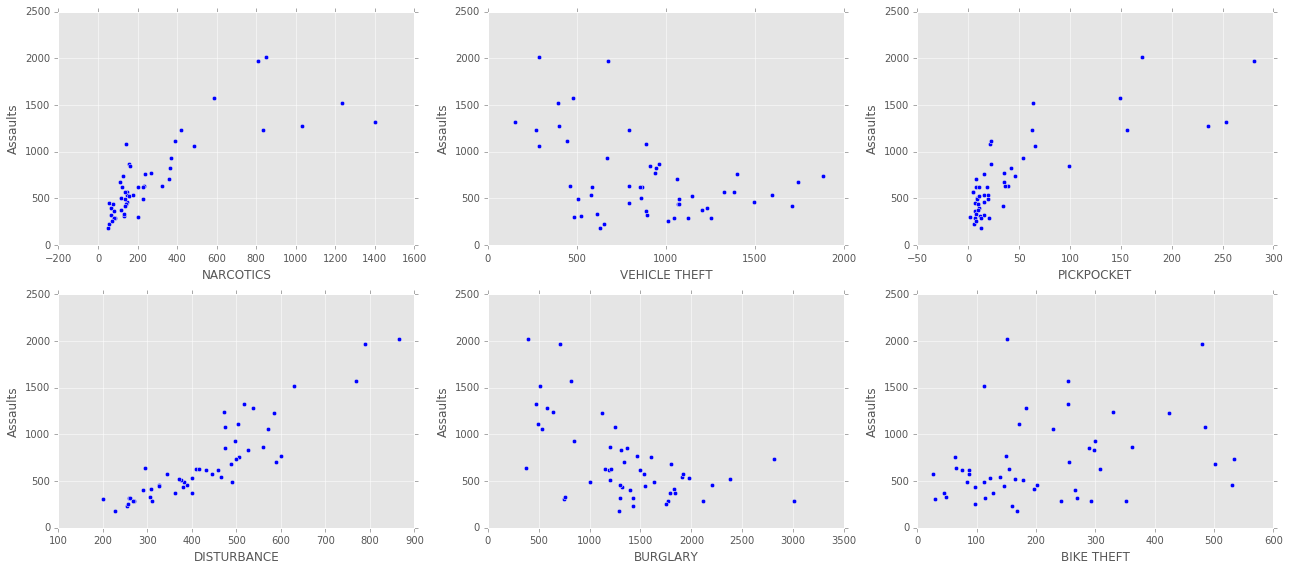

In [47]:
fig, axarr = plt.subplots(2,3,figsize = (18,8))
# lets look at a few sampled offenses
sample_offenses = ['NARCOTICS','VEHICLE THEFT', 'PICKPOCKET', 'DISTURBANCE', 'BURGLARY', 'BIKE THEFT']
for el, offense in enumerate(sample_offenses):
    index = np.unravel_index(el,(2,3))
    axarr[index[0], index[1]].scatter(beat_totals[offense], beat_totals['ASSAULT']);
    axarr[index[0], index[1]].set_xlabel(offense);
    axarr[index[0], index[1]].set_ylabel('Assaults');
    plt.tight_layout()

From the sample offenses it is pretty clear that Narcotics, Pickpocketing, and Disturbance offenses are positively correlated with Assualt offenses. Vehicle Theft and Burglary appear negatively correlatedand while Bike thefts show little correlation. Lets now examine all the offense correlations with assaults.

In [48]:
pd.DataFrame(beat_totals.corr().ASSAULT).sort_values(by='ASSAULT')

,ASSAULT
BURGLARY,-0.579044
MAIL THEFT,-0.533826
VEHICLE THEFT,-0.436190
FRAUD,-0.310059
DISPUTE,-0.271742
RECOVERED PROPERTY,-0.260422
ILLEGAL DUMPING,-0.234398
ANIMAL COMPLAINT,-0.201312
PROPERTY DAMAGE,-0.052007
ELUDING,-0.036333


## Predictive Modeling I: Assaults  Across Beats

The ordered correlation matrix shows that a number of the offenses are correlated with assaults. It also shows that some offenses are not correlated with assaults at all. Lets see if we can model the number of assaults (response) in each beat given the number of non-assault offenses in the same beat (predictors).

In [49]:
num_predictors = beat_totals.shape[1]-1
num_responses = beat_totals.shape[0]
print('We have', num_responses, 'beats reporting assaults (aka: responses) and \n', num_predictors, 
      'non-assault offenses in each beat (aka: predictors)')

We have 51 beats reporting assaults (aka: responses) and 
 51 non-assault offenses in each beat (aka: predictors)


So this is a challenging set of data because the number of responses is equal to the number of predictors. However, based on the correlation results we think that some of these predictors are not related to the response. This means we have predictors that could be adding noise (variance) to the model. This is a scenario where subset selection or regularization models can help. They trade off a little bias for a greater reduction in variance to improve a models Test MSE. Lets make the full least squares model and then compare with the lasso regularizzation model using the scikit-learn library.

In [50]:
# The beat totals dataframe contains NaNs. These are where an offense did not occur in a beat. 
# We will set these to 0. 
beat_totals = beat_totals.fillna(value=0)

In [51]:
# create a list of the predictor columns removing the Assault response column.
predictors = beat_totals.columns.tolist()
predictors.remove('ASSAULT')

### Least Squares Model and LOOCV Test MSE Estimate

In [52]:
# Create a linearRegression model
np.random.seed(0)
ls_model = LinearRegression()
# perform a LOOCV using the model returning the estimated Test MSE
ls_mse = -np.mean(cross_val_score(ls_model, beat_totals[predictors], beat_totals.ASSAULT,
                                  scoring='mean_squared_error', cv=len(beat_totals)))

print('LOOCV Estimate of Least Squares Test MSE = ', ls_mse)

LOOCV Estimate of Least Squares Test MSE =  134444.285877


In [53]:
# The percentage error is approximately
print('% Error is ~', np.sqrt(ls_mse)/beat_totals.ASSAULT.mean()*100)
# This is approximate because technically %Error is RSE/mean(ASSUALTS) RSE = sqrt(RSS/n-p-1),
# we are approximating it as sqrt(RSS/n)/mean(ASSAULTS) so we are overestimating the error

% Error is ~ 51.8321109051


### Lasso Regression Model and LOOCV Test MSE Estimate

We suspect that some of the offenses are not related to the assaults. These potentially unrelated predictors may drive the variance of the model up -- thereby reducing the Test MSE. We will now try the lasso regularization model to set 'noise' predictors to 0. This increases the bias a little but may dramatically reduce the model's variance. First we need to locate the regularization 'hyperparameter' using cross-validation.

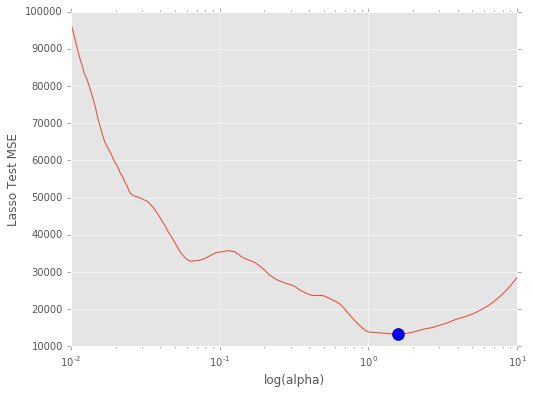

Lasso Regression LOOCV Test MSE Estimate =  13315.3591172 

Intercept                          -106.258403
ANIMAL COMPLAINT                     -0.100107
BIAS INCIDENT                         4.216823
BIKE THEFT                            0.114175
BURGLARY                             -0.037422
BURGLARY-SECURE PARKING-RES          -0.000000
CAR PROWL                             0.000000
COUNTERFEIT                          -0.624962
DISORDERLY CONDUCT                    0.000000
DISPUTE                              -0.000000
DISTURBANCE                           1.603744
DUI                                  -0.000000
ELUDING                               0.000000
EMBEZZLE                              0.991800
ESCAPE                                6.208165
EXTORTION                            -0.000000
FALSE REPORT                          0.000000
FIREWORK                              0.000000
FORGERY                              -0.000000
FRAUD                                -0.000000


In [54]:
# Fit a lasso model with 200 alpha values and LOOCV. Be sure to normalize the predictors
lambdas = 10**np.linspace(-2,1, 200)
lasso = LassoCV(alphas=lambdas, fit_intercept=True, normalize=True, cv=len(beat_totals), max_iter=10000)
lasso.fit(beat_totals[predictors], beat_totals.ASSAULT)

# get the lasso MSE by taking the mean across folds i.e. axis=1
lasso_mse = np.mean(lasso.mse_path_, axis=1)
# compute the minimum mse corresponding to the optimal alpha
min_lasso_mse = min(lasso_mse)

# Plot the best alpha, and the mse at this alpha
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lasso.alphas_, lasso_mse )
ax.plot(lasso.alpha_, min_lasso_mse, marker='o', color='b', markersize=12);
ax.set_xscale('log');
ax.set_xlabel('log(alpha)');
ax.set_ylabel('Lasso Test MSE');
plt.show()

print('Lasso Regression LOOCV Test MSE Estimate = ', min(lasso_mse),'\n')
# Print the Lasso Regression Coeffecients
print(pd.Series(data = np.hstack([lasso.intercept_, lasso.coef_]), index=['Intercept'] + predictors))

** Very cool, we have found that many of the predictors are now 0. In fact only 21 predictors remain. Lets see if this has improved the models performance...**

In [55]:
print('%Error Rate of Lasso Model is ~', np.sqrt(min(lasso_mse))/beat_totals.ASSAULT.mean()*100)

%Error Rate of Lasso Model is ~ 16.3118854829


So by regularization we have found a set of predictors that are correlated with the response and together make a model with a much lower error rate than what we found with the full least squares model.

### Actionable Insights

** Given the likelihood of multicollinearity, that is correlated offenses used as model predictors, we can not state that we know which specific offenses are predictive of the number of assaults across beats. However, our model has located a set of offenses that are correlated with assaults across Seattle PDs beats. Below are the set of offenses that our lasso model has identified:**

In [56]:
results = {predictor: coeff for predictor,coeff in zip(predictors,lasso.coef_) if np.abs(coeff)>0}
results = pd.Series(results,name='Coeffecient')
results

ANIMAL COMPLAINT                   -0.100107
BIAS INCIDENT                       4.216823
BIKE THEFT                          0.114175
BURGLARY                           -0.037422
COUNTERFEIT                        -0.624962
DISTURBANCE                         1.603744
EMBEZZLE                            0.991800
ESCAPE                              6.208165
INJURY                              2.372801
LIQUOR VIOLATION                    2.843904
LOITERING                           0.836152
MAIL THEFT                         -0.884701
NARCOTICS                           0.210433
PICKPOCKET                          0.206991
RECKLESS BURNING                    1.121688
RECOVERED PROPERTY                 -2.776422
ROBBERY                             0.099715
STAY OUT OF AREA OF PROSTITUTION   -6.515461
Name: Coeffecient, dtype: float64

** A positive coeffecient implies that an increase of that offense type in a given beat results in an increase of assaults if all other offenses are fixed. Similarly, a negative coeffecient implies that an increase in that offense type results in a decrease of assaults holding all other offenses fixed. For example, if a given district sees a rise of narcotics, embezzlements and distrubances but little change in other offense types then the model predicts an increase in assaults for that police beat. **

## Predictive Modeling II: Assaults in Time

### Visualize Assaults by Month

A natural starting place is to examine how many assaults occur in each of the 12 calendar months over the years the SPD has been reporting. Are assaults more likely during the warmer months?

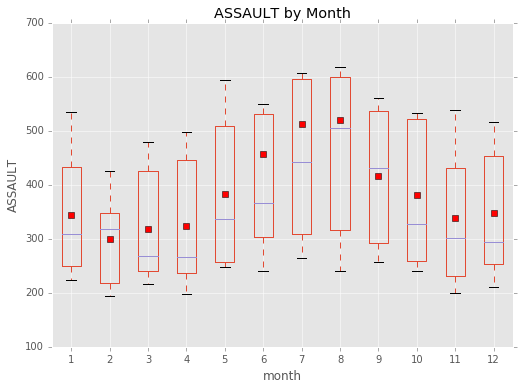

In [57]:
def offense_by_month(df, offense, beat=None):
    """
    Boxplot of the number of offense mathcing offense input. specific beat can be supplied.
    
    PARAMETERS
    ----------
    df        :dataframe with columns datetime, offense and beat
    beat      :beat string where we will count offenses 
    offenses  :str offense from df's offense column we wish to count
    
    RETURNS
    ---------
    NONE
    """
    # get from dataframe rows where offense and beat match requested offense and beat strings
    if beat:
        df2 = df.loc[(df.offense==offense) & (df.beat==beat)]
    else:
        df2 = df.loc[(df.offense==offense)]
        
    # Group the offenses by year and month and count returning a two-index series
    counts = df2['offense'].groupby([df2.datetime.dt.year, df2.datetime.dt.month]).count()
    # convert series to dataframe naming the counts as counts
    counts = counts.to_frame('counts')
    # rename the indices to year and month then reset index to integer
    counts.index.names = ['year', 'month']
    counts = counts.reset_index()
    
    # Boxplot the counts grouping by month
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    counts.boxplot(column='counts', by='month', ax=ax, showmeans=True, showfliers=False)
    fig.suptitle('')
    ax.set_title(offense +' by Month')
    ax.set_ylabel(offense)
    
    return
    
offense_by_month(df,'ASSAULT')

The boxplot of the data indicates more assaults during the months of June, July and August. So there is a weak periodicity to the time series data.

### Assault Time Series in a Beat

Now lets drill down on the actual time series of the assaults across all the reporting months.

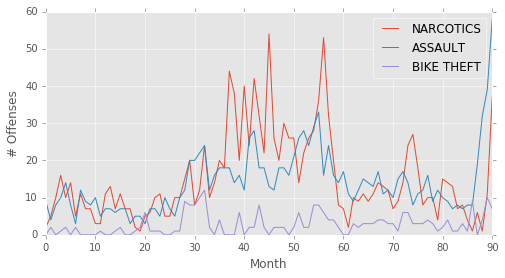

In [58]:
def offense_by_time(df, offenses, beat='M3', frequency='M'):
    """
    Plots the number of offenses, supplied in df, over time sampled at frequency.
    
    PARAMETERS
    ----------
    df        :dataframe with columns datetime, offense and beat
    beat      :beat string where we will count offenses 
    offenses  :list of offenses from df's offense column we wish to count
    frequency :datetime frequency string 'D','M', 'AS'
    
    RETURNS
    ---------
    
    """
    
    # set the datetime column to be the index for slicing
    df2 = df.set_index('datetime')
    
    # construct a list of dateTime stamps with frequency
    rng = pd.date_range(df2.index.min(), df2.index.max(), freq=frequency)
    
    # create a counts array num_offenses x num_months
    counts = np.zeros((len(offenses),len(rng)-1))
    
    fig, ax = plt.subplots(figsize=(8,4));
    
    for idx, offense in enumerate(offenses):
        
        # Get rows matching offense and beat
        df3 = df2.loc[(df2.offense==offense) & (df2.beat==beat)]
        
        # perform a count of the offenses in the timespans.
        counts[idx] = [df3[(df3.index > time1) & (df3.index < time2)].offense.count() 
                           for time1, time2 in zip(rng, rng[1:])]
        
        ax.plot(counts[idx], label=offense);
    
    ax.set_xlabel('Month');
    ax.set_ylabel('# Offenses');
    ax.legend()
    
    return counts
   
counts = offense_by_time(df, ['NARCOTICS', 'ASSAULT', 'BIKE THEFT'], beat='M3', frequency='M')

Notice that the assaults appear to have some structure across time. There are sustained periods of higher and lower assaults. This suggest that knowledge about the previous month's assault count might be predictive of the current month's assault count. Lets look at a lag plot to see if this intuition is right.

### Lag Plot of Assaults in a Beat

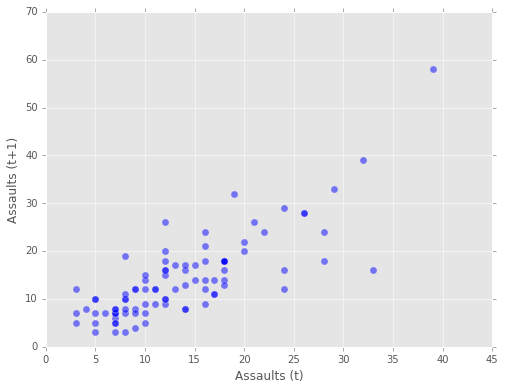

In [59]:
assaults = counts[1]
data = pd.Series(assaults)
fig, ax = plt.subplots(figsize=(8,6))
ax = lag_plot(data, c=[0,0,1], s=50, alpha=0.5);
ax.set_xlabel('Assaults (t)');
ax.set_ylabel('Assaults (t+1)');

So yes there is structure in the lag plot to indicate that knowledge about previous month's assaults may help us predict current month's assaults. We can further examine this by finding the auto-correlation at different lags.

### Auto-Correlations of Assaults in Time

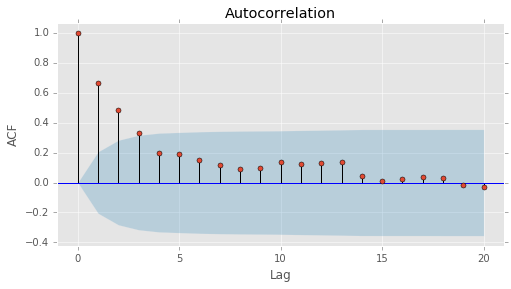

In [60]:
# Examine Autocorrelation
fig, ax = plt.subplots(figsize=(8,4))
sm.graphics.tsa.plot_acf(assaults, lags=20, ax = ax, alpha=.05)
ax.set_xlabel('Lag');
ax.set_ylabel('ACF');

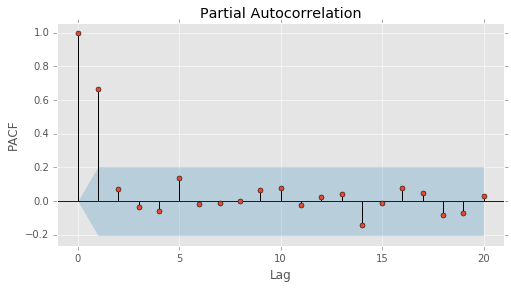

In [61]:
# Examine Partial Autocorrelations (i.e. the AC between y_t and y_t+k where depence on previous lags is removed)
fig, ax = plt.subplots(figsize=(8,4))
sm.graphics.tsa.plot_pacf(assaults, lags=20, ax = ax, alpha=.05)
ax.set_xlabel('Lag');
ax.set_ylabel('PACF');

By examining the Auto-correlation function we find that 2-3 lags are significant. When we remove the contibution from other lags the Partial Auto-Correlation shows that only one lag is significant. Also neither plot shows a lot of periodicity so we expect that a 1-lag autoregression model will work to model this data. Let's try it out.

### Autoregressive Model of Assaults

We want to build a model of the assaults in time and see if we can be predictive. To do this we will build an AR(p) model "Auto-regressive model with p-lags". The model has the form $Y_{t} = \beta_0 + \beta_1 Y_{t-1} + ... \beta_p Y_{t-p} + \epsilon_{t}$ The number of lags will be determined using an Akaike Information Criteria.

In [62]:
# Build an ar model with no linear trend using AIC to select the optimal number of Lags
# note fit auto performs difference transformation to ensure stationarity.
ar_model = AR(assaults)
ar_results = ar_model.fit(ic ='AIC', trend='nc')
print(ar_results.params)

[ 1.01770614]


So in agreement with our intuition above, the AIC criteria has picked a 1-lag model with a slope close to 1. This is just like a random walk model $Y_t = Y_{t-1} + \epsilon_{t-1}$. No suprise, this kind of model works well on all sorts of econometric data that looks very similiar to the assaults data.

### AR Model Fit

Over many points the AR(1) model should converge to roughly the mean of the data, so we don't expect to be able to perform any long-term predictions. This makes sense given that our model has only one lag. Lets see how well we do if we simply predict the assaults in a given month based on the previous month's assaults...

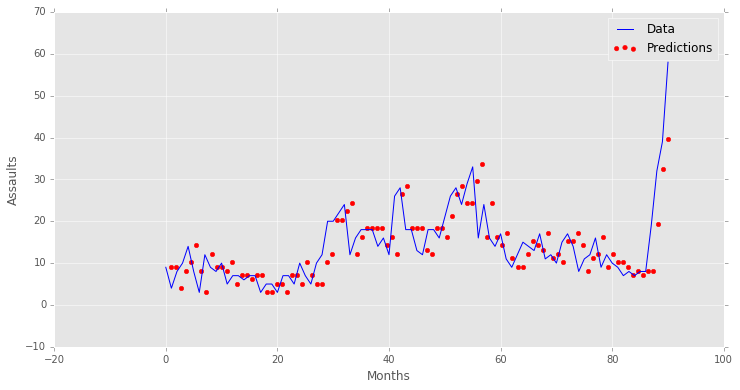

In [63]:
# Plot the predictions for a set of months
months = np.linspace(1,90,100)
# predict only one month out each time
predictions = np.array([ar_results.predict(start=int(month), end=int(month), dynamic=True) for month in months])

# Plot the actual data and the predicted data for each month
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(assaults,color='b', label='Data');
ax.scatter(months, predictions, color='r', label='Predictions');
ax.legend();
ax.set_xlabel('Months');
ax.set_ylabel('Assaults');

So you can see where errors are made; in high assault months we will tend to predict high assaults in the following month and for months with low assaults we predict low assaults in the following month. This doesn't work for extremely high or low values but it does ok for values near the mean.

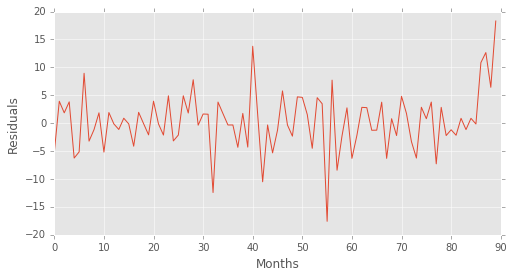

In [64]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(ar_results.resid);
ax.set_ylabel('Residuals');
ax.set_xlabel('Months');

Now that we know errors occur at the extreme values or rapid changes in assaults we can see how good of a fit we are doing over-all.

In [65]:
# compute the mean absolute error
def mean_absolute_err(y, yhat):
    return np.abs(np.mean(np.mean((y[1:]-yhat))/yhat))

# compute the mean forecasting error rate
def mean_forecast_err(y,yhat):
    return np.mean(y[1:]-yhat)

all_predictions = ar_results.predict(dynamic=True)
print('Mean Forecast Error is:', mean_forecast_err(assaults, all_predictions))
print('Absolute Error Rate is:' ,mean_absolute_err(assaults, all_predictions))

Mean Forecast Error is: -8.01311984526
Absolute Error Rate is: 0.443591025477


** The forecast error is positive meaning that we are undershooting the actual data but not by much. The absolute error is ~14%. So on any given month the model is within 14% of the actual number, though as we saw earlier our confidence in this number is low when we have very few or very many assaults. Also it is important to note that the AR(1) coeffecient was determined over the whole-data set --- so we are underestimating the error rate, since we are making predictions on data that has already been fit. A better way to be more accurate with this would be to perform a cross-validation procedure. **

## Actionable Insights

The AR(1), "random walk", model predicts the assualts in a given month based on the previous month's assaults in the M3 police beat. This monthly "lag", choice was made by determining the AIC information criteria and examining autocorrelation plots. The model fits well with about a 14% error rate in predicting the number of assaults that will occur in the following month. While the model fails to capture rapidly changing numbers of assaults in time, it correctly identifies the sustained monthly periods that have low or high numbers of assault.